## Tutorial: how to import the data and visualise them

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
#from tree import FamilyTree
from data_handler import ParticleDataset

import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch

#helper functions for plots
from utils.visualisation import plot_geodesic, get_colors, hard_descendants
from utils.metrics import sqdist, distance_matrix, precision_and_recall, mAP

from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

INFO: Using numpy backend


## The dataset

The dataset is structured as a Pytorch dataset. The two inputs are the path for the data directory and the signal name (this depends on the physics event we are interested in and it is chosen once the data is generated).

The dataset spits each event as dictionary which contains a graphicle object and a hyperbolic coordinates array for each of the algorithm tree (AntiKt, CA and Kt) and for the MC truth.

In [2]:
dataset = ParticleDataset('data/test3', 'signal')
event = dataset[15]

### For test3 I used: lr=0.5, epochs=150, steps=10
### For test2 I used: lr=0.3, epochs=120, steps=7

In [3]:
event.keys()

dict_keys(['MC_graph', 'MC_hyp', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp'])

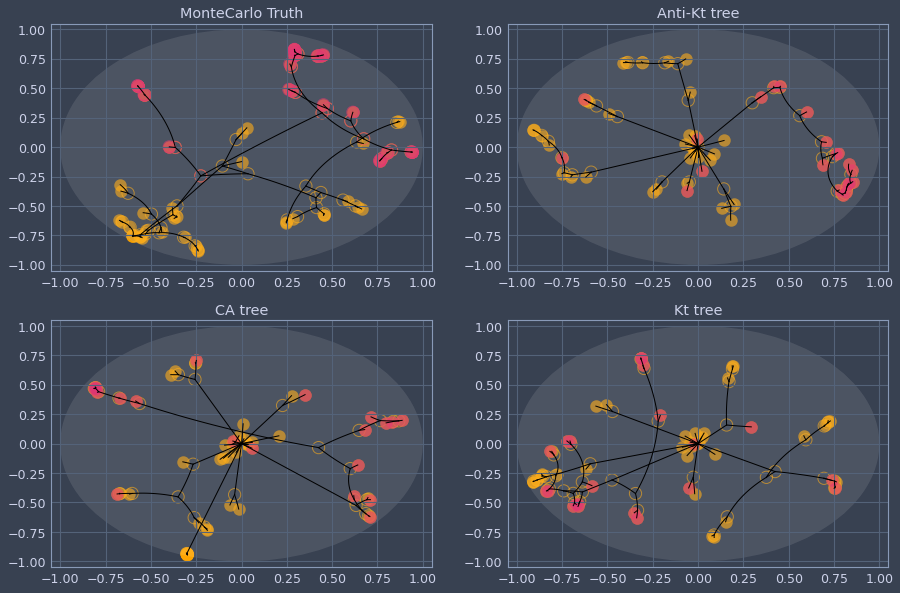

In [119]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.flatten()

keys = [k for k in event.keys()]
titles = [ 'MonteCarlo Truth', 'Anti-Kt tree', 'CA tree', 'Kt tree',]
for k in range(0, 7, 2):
    i = k//2
    graph, hyp = event[keys[k]], event[keys[k+1]]
    
    for edge in graph.edges:
        start = np.where(graph.nodes == edge[0])[0][0]
        end = np.where(graph.nodes == edge[1])[0][0]
        x0,y0 = hyp[start]
        x1,y1 = hyp[end]
        #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
        plot_geodesic(hyp[start],hyp[end],ax[i])
    
    if i ==0:
        #'#DB2065'
        mask = graph.final.data
        ax[i].scatter(hyp[:,0][mask], hyp[:,1][mask], 
            c='orange', s=150, alpha=0.6)
        ax[i].scatter(hyp[:,0][~mask], hyp[:,1][~mask], 
            facecolor='none',edgecolor='orange',linewidth=1, s=150, alpha=0.6)
        
        hard_mask = hard_descendants(graph, 25)
        ax[i].scatter(hyp[:,0][hard_mask * mask], hyp[:,1][hard_mask * mask], 
            c='#DB2065', s=150, alpha=0.6)
        ax[i].scatter(hyp[:,0][hard_mask], hyp[:,1][hard_mask], 
            facecolor='none',edgecolor='#DB2065',linewidth=1, s=150, alpha=0.6)
        
        hard_mask = hard_mask[mask]
                      
    else:
        mask = graph.final.data
        
        colors = np.array(get_colors(graph))
        ax[i].scatter(hyp[:,0][mask], hyp[:,1][mask], 
            c='orange', s=150, alpha=0.6)
        ax[i].scatter(hyp[:,0][~mask], hyp[:,1][~mask], 
            facecolor='none',edgecolor='orange',linewidth=1, s=150, alpha=0.6)
        
        ax[i].scatter(hyp[:,0][mask][hard_mask], hyp[:,1][mask][hard_mask], 
            c='#DB2065', s=150, alpha=0.6)
        #ax[i].scatter(hyp[:,0][mask][~hard_mask], hyp[:,1][mask][~hard_mask], 
        #    facecolor='none',edgecolor='#DB2065',linewidth=1, s=150, alpha=0.6)
    
    disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
    ax[i].add_patch(disk)
    ax[i].set_xlim(-1.05,1.05)
    ax[i].set_ylim(-1.05,1.05)
    ax[i].set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## Distance matrices analysis

In [5]:
n_event = 50
record = np.zeros((n_event, 3))
for ev in tqdm(range(n_event)):
    event = dataset.__getitem__(ev)
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    mc_m = distance_matrix(hyp[graph.final, :])
    temp_record = []
    #if len(mc_m) < 1:
    #    print('something happened', ev)
        #record[ev] = [-1, -1, -1]
    #    continue
        
    for k in [2,4,6]:
        graph, hyp = event[keys[k]], event[keys[k+1]]
        temp_m = distance_matrix(hyp[graph.final, :])
        #if len(temp_m) < 1:
        #    print('something happened', ev)
            #temp_record.append(-1)
        #    continue
        temp_record.append(np.sum(np.square(mc_m - temp_m)))
    record[ev] = temp_record
    

print(f'mean: {np.mean(record, 0)}')
print(f'min: {np.min(record, 0)}')
print(f'max: {np.max(record, 0)}')
print(f'median: {np.median(record, 0)}')

100%|████████████████████████████████| 50/50 [00:03<00:00, 15.42it/s]

mean: [139721.65249319 140054.10635226 136788.04860625]
min: [12291.47534328 12640.75712146 13218.49857195]
max: [512665.19023748 455297.56732924 561960.06358095]
median: [107821.43037294 102343.10314892 103626.22424161]


In [6]:
n_event = 50
record = np.zeros((n_event, 3))
for ev in tqdm(range(n_event)):
    event = dataset.__getitem__(ev)
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    
    mask = graph.final.data
    hard_mask = hard_descendants(graph, 25)
    
    mc_m = distance_matrix(hyp[mask * hard_mask, :])
    hard_mask = hard_mask[mask]
    temp_record = []
    #if len(mc_m) < 1:
    #    print('something happened', ev)
        #record[ev] = [-1, -1, -1]
    #    continue
        
    for k in [2,4,6]:
        graph, hyp = event[keys[k]], event[keys[k+1]]
        mask = graph.final.data
        temp_m = distance_matrix(hyp[mask, :][hard_mask])
        
        #if len(temp_m) < 1:
        #    print('something happened', ev)
            #temp_record.append(-1)
        #    continue
        temp_record.append(np.sum(np.square(mc_m - temp_m)))
    record[ev] = temp_record
        
print(f'mean: {np.mean(record, 0)}')
print(f'min: {np.min(record, 0)}')
print(f'max: {np.max(record, 0)}')
print(f'median: {np.median(record, 0)}')

100%|████████████████████████████████| 50/50 [00:02<00:00, 16.87it/s]

mean: [7137.51271584 7281.58738666 6568.72154739]
min: [18.973685   50.74753715 18.84987827]
max: [44269.92790372 42267.1731698  47304.7732823 ]
median: [2288.09153912 3292.17385422 2521.47175152]


In [7]:
n_event = 50
record = np.zeros((n_event, 3))
for ev in tqdm(range(n_event)):
    event = dataset.__getitem__(ev)
    k=0
    graph, hyp = event[keys[k]], event[keys[k+1]]
    temp = []
    for k in [2,4,6]:
        graph2, hyp2 = event[keys[k]], event[keys[k+1]]
        temp.append(np.mean(sqdist(hyp[graph.final, :], hyp2[graph2.final, :])))
        
    record[ev] = temp
    
print(f'mean: {np.mean(record, 0)}')
print(f'min: {np.min(record, 0)}')
print(f'max: {np.max(record, 0)}')
print(f'median: {np.median(record, 0)}')

100%|████████████████████████████████| 50/50 [00:02<00:00, 17.79it/s]

mean: [10.05788753  9.87801207  9.38664464]
min: [5.47483079 6.22182873 5.4577219 ]
max: [21.53878821 19.06890519 16.6222181 ]
median: [9.48066368 9.29541357 8.93293562]


## Local graph metric - mean average precision (mAP)

In [8]:
dataset = ParticleDataset('data/test3', 'signal')
n_events = 250
total_mAP = np.zeros((n_events, 4))

for ev in tqdm(range(n_events)):
    event = dataset.__getitem__(ev)
    total_mAP[ev] = mAP(event)

cols = ['MC', 'Anti-Kt', 'CA', 'Kt']
rows = ['Average mAP', 'Min mAP', 'Max mAP', 'Median mAP']
#total_mAP = np.mean(total_mAP, axis=0)

df = pd.DataFrame(
    [np.mean(total_mAP, axis=0),
    np.min(total_mAP, axis=0),
    np.max(total_mAP, axis=0),
    np.median(total_mAP, axis=0)], index=rows, columns=cols)
df

100%|██████████████████████████████| 250/250 [00:33<00:00,  7.47it/s]


,MC,Anti-Kt,CA,Kt
Average mAP,0.727269,0.640554,0.628557,0.638657
Min mAP,0.620840,0.442157,0.388562,0.444304
Max mAP,0.846198,0.797553,0.769718,0.805029
Median mAP,0.726592,0.645755,0.636220,0.645294


## Precision and Recall

For any tree ...

In [9]:
dataset = ParticleDataset('data/test3', 'signal')
n_events = 250
precision = np.zeros((n_events, 4))
recall = np.zeros((n_events, 4))

for ev in tqdm(range(n_events)):
    event = dataset.__getitem__(ev)
    precision[ev], recall[ev] = precision_and_recall(event)

cols = ['MC', 'Anti-Kt', 'CA', 'Kt']
rows = ['Precision', 'Recall']
precision = np.mean(precision, axis=0)
recall = np.mean(recall, axis=0)

df = pd.DataFrame([precision, recall], index=rows, columns=cols)
df

100%|██████████████████████████████| 250/250 [00:17<00:00, 14.04it/s]


,MC,Anti-Kt,CA,Kt
Precision,0.923557,0.647838,0.666656,0.637330
Recall,0.898836,0.623129,0.638275,0.626018


## Testing Sarkar algorithm

In [5]:
%run tree.py

In [13]:
#dataset = ParticleDataset('data/test', 'signal')
#event = dataset[15]

dataset = ParticleDataset('data/higgs_tagging/signal', 'signal')
event = dataset[1]
graph = event['MC_graph']

tree = FamilyTree(graph)
g = tree.history(p=0)


In [62]:
from hyperlib.embedding.sarkar import sarkar_embedding

#G = nx.balanced_tree(2,5)
#graph = event['Kt_graph']
G = nx.Graph()
#G.add_edges_from(akt.edges[1:])
G.add_edges_from(graph.edges)
nodes = np.array(G.nodes())
mapping = {nodes[i]: i for i in range(len(nodes))}
G = nx.relabel_nodes(G, mapping)
#G = nx.balanced_tree(3,4)
embed = sarkar_embedding(tree=G, root=mapping[-1], tau=0.7, weighted=False)#, tau=tau)
#plot_embedding(T, emb, labels=labels)
hyp = np.array(list(map(float, embed))).reshape(-1,2)

In [63]:
distances = distance_matrix(hyp, off_diag=False)
mAP = 0
nodes = np.array(list(G.nodes()))
for node_idx in range(len(nodes)):
    node = nodes[node_idx]
    # get the neighbours of a node
    neighbours = list(G.neighbors(node))
    temp_mAP = 0
    for neigh in neighbours:
        # define the circle's radius
        neigh_idx = np.where(nodes == neigh)[0]
        radius = distances[node_idx][neigh_idx][0]

        # find all the nodes within the circle
        radius_mask = distances[node_idx] <= radius
        # remove self loop
        radius_mask[node_idx] = False

        nodes_in_circle = nodes[radius_mask]
        # count how manyy should be there
        num = len(set(nodes_in_circle).intersection(set(neighbours)))
        den = len(nodes_in_circle)

        temp_mAP  += num / den

    mAP += temp_mAP / len(neighbours)

mAP /= G.number_of_nodes()
mAP

1.0

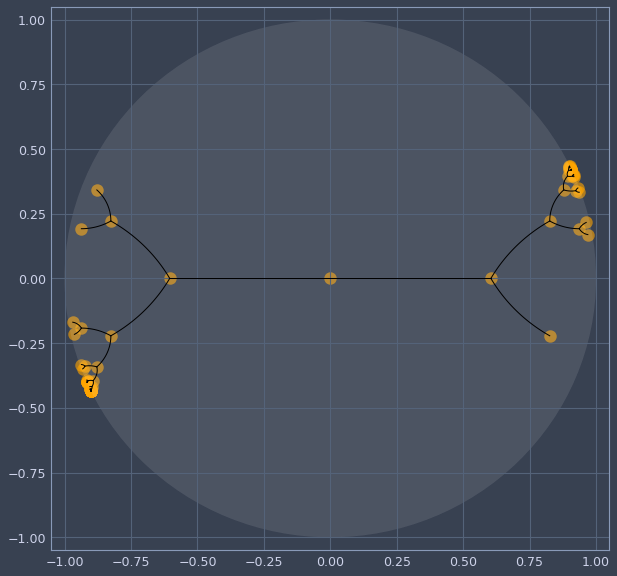

In [59]:
fig,ax = plt.subplots(figsize=(10,10))

nodes = np.array(G.nodes())
for edge in G.edges:
    start = np.where(nodes == edge[0])[0][0]
    end = np.where(nodes == edge[1])[0][0]
    x0,y0 = hyp[start]
    x1,y1 = hyp[end]
    #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
    plot_geodesic(hyp[start],hyp[end],ax)

'''
graph = event['MC_graph']
mask = graph.final.data
hard_mask = hard_descendants(graph, 25)
hard_mask = hard_mask[mask]

graph = event['Kt_graph']
mask = graph.final.data
ax.scatter(hyp[:,0][mask], hyp[:,1][mask], 
    c='orange', s=150, alpha=0.6)
#ax.scatter(hyp[:,0][~mask], hyp[:,1][~mask], 
#    facecolor='none',edgecolor='orange',linewidth=1, s=150, alpha=0.6)

#ax.scatter(hyp[:,0][mask][hard_mask], hyp[:,1][mask][hard_mask], 
#    c='#DB2065', s=150, alpha=0.6)    
'''
    
    
ax.scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
  
disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
ax.add_patch(disk)
ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
#ax.set_title(titles[i])

plt.show()
#plt.savefig('example.png')

In [60]:
dataset = ParticleDataset('data/higgs_tagging/background_full', 'background')
event = dataset[100]
dataset.__len__()

9997

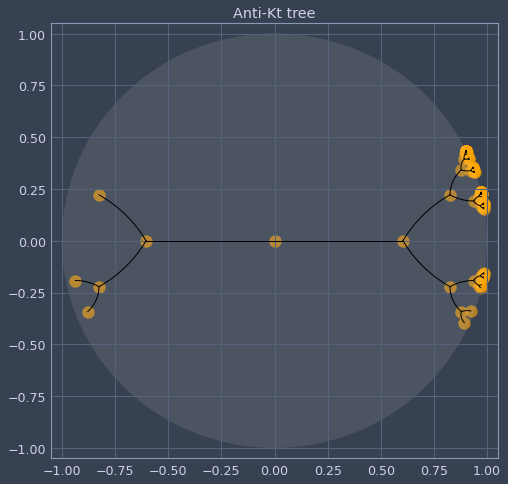

In [61]:
fig,ax = plt.subplots(figsize=(8,8))

keys = [k for k in event.keys()]
titles = [ 'Anti-Kt tree', 'CA tree', 'Kt tree',]
k=1
graph, hyp = event[keys[k]], event[keys[k+1]]
    
G = nx.Graph()
G.add_edges_from(graph.edges)
nodes = np.array(G.nodes())
mapping = {nodes[i]: i for i in range(len(nodes))}
G = nx.relabel_nodes(G, mapping)
nodes = np.array(G.nodes())
for edge in G.edges:
    start = np.where(nodes == edge[0])[0][0]
    end = np.where(nodes == edge[1])[0][0]
    x0,y0 = hyp[start]
    x1,y1 = hyp[end]
    #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
    plot_geodesic(hyp[start],hyp[end],ax)
    
ax.scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
    
disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
ax.add_patch(disk)
ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
ax.set_title(titles[0])

plt.show()
#plt.savefig('example.png')